In [1]:
using Revise

In [96]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper.jl")
working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
;

### Set up the molecule

In [97]:
package = get_CaOH_package();
n_states = length(package.states)
n_excited = package.n_excited;

### Ramp B field

In [98]:
function update_H(H, p, r, τ)
    Zeeman_Hz = p.extra_p.Zeeman_Hz
    Zeeman_Hx = p.extra_p.Zeeman_Hx
    Zeeman_Hy = p.extra_p.Zeeman_Hy
    
    # ramp the magnetic field
    scalar = 0.3 * exp(τ/p.extra_p.ramp_time)
    scalar = min(scalar, 1.0)
    
    gradient_z = scalar * p.extra_p.gradient_z
    gradient_x = scalar * p.extra_p.gradient_x
    gradient_y = scalar * p.extra_p.gradient_y
    @turbo for i in eachindex(H)
        H.re[i] = gradient_z * Zeeman_Hz.re[i] * r[3] + gradient_x * Zeeman_Hx.re[i] * r[1] + gradient_y * Zeeman_Hy.re[i] * r[2]
        H.im[i] = gradient_z * Zeeman_Hz.im[i] * r[3] + gradient_x * Zeeman_Hx.im[i] * r[1] + gradient_y * Zeeman_Hy.im[i] * r[2]
    end
    return nothing
end;

## Helper functions:

### plotting:
plot_trajectories(results, direction)

plot_all_trajectories(results, direction)

plot_velocities(results, direction)

plot_size(results, direction) -> final size

plot_temperature(results, direction) -> final temperature

plot_scattering_rate(results) -> average number of photons scattered

### saving:

make_scan_folder(lists, working_dir, scan_i, comments) -> saving_dir

log_test_info(saving_dir, test_i, params) -> actual test_i

save_results(saving_dir, test_i, results)

### loading:

load_test_params(saving_dir, test_i) -> param

load_results(saving_dir, test_i) -> results

### displaying:

display_test_info(saving_dir, test_i)

summarize_results(saving_dir, test_i)

summarize_results(results)

### re-analyzing results with arbitary threshold:

reanalyze_results!(results, r_max)


## Run a single configuration

In [141]:
temp = @with_unit 0.0 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]


# current optimum:
params = MutableNamedTuple(t_end = 30e-3, n_values = 20,
                            pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
                            s1=3.33, s2=0.0, s3=0.14, s4=0.21,
                            Δ1=1.32Γ, Δ2=-0.8Γ, Δ3=-2.0Γ, Δ4=0.90Γ, 
                            B_gradient = 30, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = 15e-3)

# test_i = log_test_info(working_dir,1,params)

@time results = simulate_particles(package, params, params.n_values);

# save_results(working_dir, test_i, results)

128.047426 seconds (1.78 G allocations: 159.536 GiB, 16.57% gc time)


In [142]:
summarize_results(results)

--------------------------------------------------
Molecules trapped: 14 out of 20
Final cloud size: (0.26, 0.19, 0.26) mm
Final temperature: (20.53, 15.54, 42.66) μK
Average photons scattered: 14159
Average scattering rate: 0.472 MHz
--------------------------------------------------


In [ ]:
# current optimum:
params = MutableNamedTuple(t_end = 30e-3, n_values = 20,
                            pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
                            s1=3.33, s2=0.0, s3=0.14, s4=0.21,
                            Δ1=1.32Γ, Δ2=-0.8Γ, Δ3=-2.0Γ, Δ4=0.90Γ, 
                            B_gradient = 30, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = 10e-3)

In [144]:
reanalyze_results!(results, 1.0);

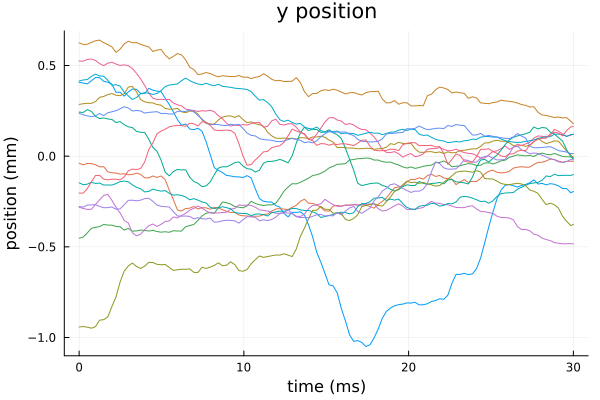

In [148]:
plot_trajectories(results, "y")
plot!()

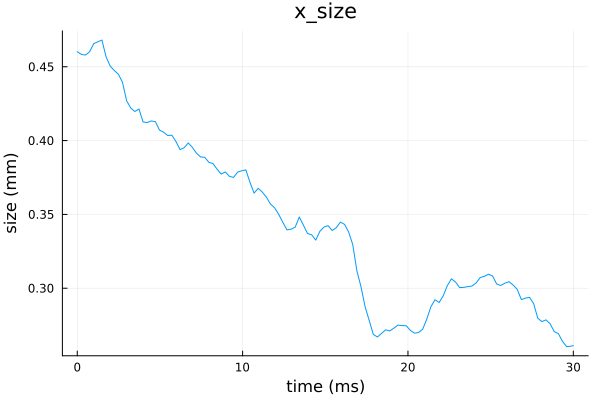

┌ Warning: G:\My Drive\github\UnitsToValue\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\packagedef.jl:574
┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\packagedef.jl:574
┌ Warning: G:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\packagedef.jl:574


In [153]:
plot_size(results, "x")
plot!()

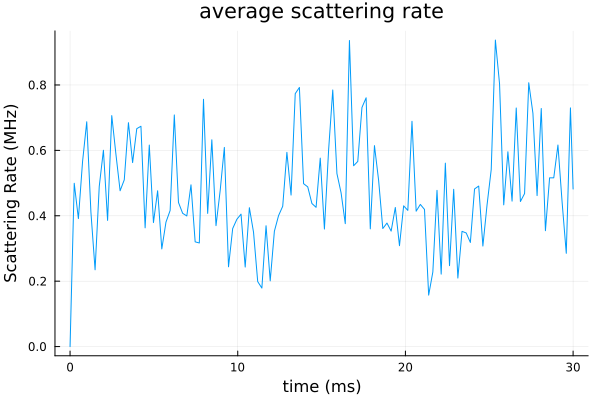

In [134]:
plot_scattering_rate(results)
plot!()

In [135]:
summarize_results(results)

--------------------------------------------------
Molecules trapped: 36 out of 40
Final cloud size: (0.18, 0.22, 0.14) mm
Final temperature: (21.95, 22.76, 24.68) μK
Average photons scattered: 14299
Average scattering rate: 0.477 MHz
--------------------------------------------------


## Scan configurations

In [27]:
function next_configuration!(lists, indicies)
   for which_param in 1:length(lists)
       if indicies[which_param] < length(lists[which_param])
           indicies[which_param] += 1
            break
        else # set this param to index q, try to increase the next next param
            indicies[which_param] = 1
        end
    end
end
;

In [10]:
# fixed:
t_end = 30e-3 #s
n_values = 40
ramp_time = 10e-3 #s
B_gradient = 30 #G/cm

temp = @with_unit 1.0 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]


# variable:
pol1_x_list = [σ⁻]
pol2_x_list = [σ⁺]
pol3_x_list = [σ⁻]
pol4_x_list = [σ⁻]

s1_list = [0.5, 1.0,2.0,3.0,4.0]
s2_list = [0.0]
s3_list = [0.5, 1.0,2.0,3.0,4.0]
s4_list = [0.0]

Δ1_list = [0.5, 0.75,1.0,1.25,1.5].*Γ
Δ2_list = [-0.8Γ]
Δ3_list = [0.5, 0.75,1.0,1.25,1.5].*Γ
Δ4_list = [-0.8Γ]

lists = [pol1_x_list, pol2_x_list, pol3_x_list, pol4_x_list,
        s1_list, s2_list, s3_list, s4_list,
        Δ1_list, Δ2_list, Δ3_list, Δ4_list]

n_scans = 1
for l in lists
   n_scans *= length(l) 
end

comments = "scan d3 +- 1MHz";
saving_dir = make_scan_folder(lists, working_dir, 1, comments);

scan_counter = 0
indicies = [1,1,1,1, 1,1,1,1, 1,1,1,1];

In [11]:
n_scans 

625

In [30]:
# resume scan half-way: 

# scan_counter = 0
# indicies = [1,1,1,1, 1,1,1,1, 1,1,1,1]
# while scan_counter < 126
#     scan_counter += 1
#     next_configuration!(lists, indicies)
# end;

In [32]:


while scan_counter < n_scans
    @printf("============= configuration %i / %i =============", scan_counter+1, n_scans)
    println()
    
    pol1_x = pol1_x_list[indicies[1]]
    pol2_x = pol2_x_list[indicies[2]]
    pol3_x = pol3_x_list[indicies[3]]
    pol4_x = pol4_x_list[indicies[4]]
    s1 = s1_list[indicies[5]]
    s2 = s2_list[indicies[6]]
    s3 = s3_list[indicies[7]]
    s4 = s4_list[indicies[8]]
    Δ1 = Δ1_list[indicies[9]]
    Δ2 = Δ2_list[indicies[10]]
    Δ3 = Δ3_list[indicies[11]]
    Δ4 = Δ4_list[indicies[12]]
    
    params = MutableNamedTuple(t_end = t_end, n_values = n_values,
                            pol1_x=pol1_x, pol2_x=pol2_x, pol3_x=pol3_x, pol4_x=pol4_x, 
                            s1=s1, s2=s2, s3=s3, s4=s4,
                            Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                            B_gradient = B_gradient, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = ramp_time)

    test_i = log_test_info(saving_dir,1,params)
    
    results = simulate_particles(package, params, params.n_values);

    save_results(saving_dir, test_i, results)
    
   scan_counter += 1 
   next_configuration!(lists, indicies)

    
end
;

============= configuration 127 / 625 =============
============= configuration 128 / 625 =============
============= configuration 129 / 625 =============
============= configuration 130 / 625 =============
============= configuration 131 / 625 =============
============= configuration 132 / 625 =============
============= configuration 133 / 625 =============
============= configuration 134 / 625 =============
============= configuration 135 / 625 =============
============= configuration 136 / 625 =============
============= configuration 137 / 625 =============
============= configuration 138 / 625 =============
============= configuration 139 / 625 =============
============= configuration 140 / 625 =============
============= configuration 141 / 625 =============
============= configuration 142 / 625 =============
============= configuration 143 / 625 =============
============= configuration 144 / 625 =============
============= configuration 145 / 625 =============
============

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\0XOAI\src\integrator_interface.jl:580


============= configuration 328 / 625 =============
============= configuration 329 / 625 =============
============= configuration 330 / 625 =============
============= configuration 331 / 625 =============
============= configuration 332 / 625 =============
============= configuration 333 / 625 =============
============= configuration 334 / 625 =============
============= configuration 335 / 625 =============
============= configuration 336 / 625 =============
============= configuration 337 / 625 =============
============= configuration 338 / 625 =============
============= configuration 339 / 625 =============
============= configuration 340 / 625 =============
============= configuration 341 / 625 =============
============= configuration 342 / 625 =============
============= configuration 343 / 625 =============
============= configuration 344 / 625 =============
============= configuration 345 / 625 =============
============= configuration 346 / 625 =============
============

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\0XOAI\src\integrator_interface.jl:580


============= configuration 484 / 625 =============
============= configuration 485 / 625 =============
============= configuration 486 / 625 =============
============= configuration 487 / 625 =============
============= configuration 488 / 625 =============
============= configuration 489 / 625 =============
============= configuration 490 / 625 =============
============= configuration 491 / 625 =============
============= configuration 492 / 625 =============
============= configuration 493 / 625 =============
============= configuration 494 / 625 =============
============= configuration 495 / 625 =============
============= configuration 496 / 625 =============
============= configuration 497 / 625 =============
============= configuration 498 / 625 =============
============= configuration 499 / 625 =============
============= configuration 500 / 625 =============
============= configuration 501 / 625 =============
============= configuration 502 / 625 =============
============

┌ Error: Error watching manifest
│   exception =
│    MethodError: no method matching (::OpenSSL_jll.var"#make_wrapper_dict#6"{OpenSSL_jll.var"#parse_wrapper_platform#5"})(::String, ::Vector{String})
│    Stacktrace:
│     [1] top-level scope
│       @ C:\Users\halla\.julia\packages\JLLWrappers\QpMQW\src\toplevel_generators.jl:156
│    Revise evaluation error at C:\Users\halla\.julia\packages\JLLWrappers\QpMQW\src\toplevel_generators.jl:156
│    
│    Stacktrace:
│     [1] methods_by_execution!(recurse::Any, methodinfo::Revise.CodeTrackingMethodInfo, docexprs::Dict{Module, Vector{Expr}}, mod::Module, ex::Expr; mode::Symbol, disablebp::Bool, always_rethrow::Bool, kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
│       @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\lowered.jl:227
└ @ Revise C:\Users\halla\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
┌ Error: Error watching manifest
│   exception =
│    MethodError: no method matching (::OpenSSL_jll.var"#m